# Brief

1. You will write code for (Deep Transformer Q Network, that uses a Decision Transformer and a Time Series Transformer. There will be 2 DTQN's, one of type 1 and another of type 2, and there will be 4 agents in total, there will be 2 agents using the same DTQN type 1 network, and 2 agents using the same DTQN type 2 network) multiple agents in a square grid world to learn a simple transport task that requires coordination between the agents.
2. You must use Deep-Q to let the agents learn this task. The task is split into two parts that now require a handover between two agents.
3. You will also use game theory to analyse the behaviour of these agents.
4. Your agents still have four actions that they can execute: move north/move south/move west/move east.
5. Each agent starts at a random location.
6. Items need to be transported from a location A to a location B. These
locations are fixed (A in the top-left corner, B in the bottom-right corner).
7. There are two types of agents: Type 1 can pick up at A but not deliver at B. Type 2 can deliver at B but not pick up at A. A successful transport thus now requires a handover between a Type 1 agent and a Type 2 agent.
8. Each agent can only carry a single item at a time.
9. We are imposing a quadratically increasing cost on moving. This means that
an agent who has moved n steps has a cost of n^2 for this. This is best implemented as a penalty at the handover point. Let’s assume that, disregarding this penalty, you give a constant reward of c for a successful handover to each agent when two agents meet and hand over. Each should then receive only an actual reward of c-d^2, where d is the distance
that this agent has travelled to the pickup point.
10. Agents execute the pick-up and drop-off automatically. When a Type 1 agent reaches A they automatically pick up an item provided they carry none. When a Type 2 agent reaches B they automatically drop off the item that they carry provided they carry one. Handover is also automatic: if a Type 1 agent carrying an item meets a Type 2 agent not carrying an item (in the same grid cell) the item is automatically handed over from A to B.
11. To keep the learning time within limits we work on a small grid (5x5 as before) and we only use 2 agents of each type, ie. four agents in total.
12. To further speed up the learning, all agents of the same type should share the same DTQN.
13. The agents can observe the locations of all other agents (including their own), as well as the load status of all agents (whether the agent is carrying an item).
14. The locations of A and B don’t need to be observed as these are fixed.
15. All agents perform their synchronously. This means that you first select the actions for all agents, let them perform their actions and then calculate the rewards based on the outcomes of those actions.
16. Because we have multiple agents, so the only sensible way to
implement this is by using a class for the agents. Since you also need multiple DTQNs (one combination of target and prediction network for each agent type).

# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime
import torch
import copy
from collections import deque
from random import sample
from tqdm import trange
import torch.nn as nn
import os


# Environment and GridWorld

In [2]:
####################################################

# ENVIRONMENT

####################################################

class Environment():
    def __init__(self, n):
        self.n = n
        self.elements = {
            'target': {'position': (n-1, 0)},
            'item': {'position': (0, n-1)}
        }
        self.fix_target = False
        self.is_done = False
        self.agent_with_packet = set() # set of agent ID of the agents that has the packet


    def set_position(self):
        """Sets a position of any element on the grid without overlapping with others"""
        position = np.random.randint(0, self.n), np.random.randint(0, self.n)

        taken_positions = [element['position'] for element in self.elements.values()] # Position of elements cannot overlap

        while position in taken_positions:
            position = np.random.randint(0, self.n), np.random.randint(0, self.n)

        return position

    def get_grid_size(self):
        """Returns: int n which means the environment is a grid of shape nxn"""
        return self.n


    def reset_grid(self):
        '''Resets the position of the given agent and the item, and item_picked is set to False'''
        self.is_done = False
        self.agent_with_packet.clear()
        for agent_id in  [elem for elem in self.elements if elem != 'target' and elem != 'item']:
            self.elements[agent_id]['position']  = self.set_position()
            self.elements[agent_id]['has_item'] = False
            self.elements[agent_id]['is_done'] = False


    def add_agent_to_env(self, type):
        """Adds an agent to the grid by initialising its position(tuple).
        Creates and agent_id and stores {agent_id: position} as {key:value} in self.agents
        Returns: agent_id (int)
        """
        agent_id = len([ elem for elem in self.elements if elem !='target' and elem != 'item'])+1

        self.elements[agent_id] = {
            'position': self.set_position(),
            'has_item': False,
            'type': type,
            'is_done': False
        }


        return agent_id

    def get_position (self, element_key):
        """ Returns: tuple with (x,y) position for the element"""
        element = self.elements.get(element_key)
        position = element.get('position')
        return position



    def change_agent_position(self, agent_id, action):
        """ Given the action the agent wants to take, it updates the position for the agent.
        If the agent tries to move outside the grid, the position remains the same.
        This method returs True if the agent picked the item in this step and None otherwise.
        """
        agent = self.elements[agent_id]

        #Get agent position
        (Xa,Ya) = agent['position']

        new_position = None

        #Allow move if it kees agent inside the grid and store new position
        if action == "up" and Ya < self.n - 1:
            new_position = (Xa , Ya + 1)
        elif action == "down" and Ya > 0:
            new_position = (Xa , Ya - 1)
        elif action == "left" and Xa > 0:
            new_position = (Xa - 1 , Ya)
        elif action == "right" and Xa < self.n - 1:
            new_position = (Xa + 1 , Ya)
        else:
            new_position = (Xa,Ya)

        #Update agent position
        self.elements[agent_id]['position']  = new_position

    def calculate_manhattan_distance(self, agent_type, position):
        (xa, ya) = position
        if agent_type == 'A':
            (xo, yo) = self.get_position('item')
        else:
            (xo, yo) = self.get_position('target')

        return abs(xo - xa) + abs(yo - ya)


    def calculate_reward(self, agent, current_state, next_state):
        """Calculate reward based on agent's actions and state transitions.
        Returns reward value
        """
        reward = -1

        if isinstance(agent, DeepTQAgent):
            if np.all(current_state[:(self.n*self.n+1)] == next_state[:(self.n*self.n+1)]):
                reward += -20  # Negative Reward for trying to go off the grid
            elif agent.handover == True:
                reward += 80
                d = self.calculate_manhattan_distance(agent.agent_type, agent.get_position())
                reward += -(d**2)
            elif agent.agent_type == 'A' and agent.pickup == True:
                reward += 20
            elif agent.agent_type == 'B' and agent.deliver == True:
                reward += 200

        return reward



    def get_one_hot_encoding(self,position):
        grid_size = self.get_grid_size()
        num_options= grid_size**2
        x, y = position  # Unpack the tuple (X, Y)
        index = x * grid_size + y  # Convert (X, Y) into a single index
        one_hot = np.zeros(num_options)
        one_hot[index] = 1
        return one_hot

    def get_state(self, agent_id):

        #TODO: for the moment being, I'm leaving the agent of the same type. Still to analyse if it is required.
        if agent_id == 1:
            state_order = [1,2,3,4]
        elif agent_id == 2:
            state_order = [2,1, 3,4]
        if agent_id == 3:
            state_order = [3,4,1,2]
        elif agent_id == 4:
            state_order = [4,3,1,2]

        state = []

        for agent_id in  state_order:
            agent = self.elements[agent_id]
            agent_ohe = self.get_one_hot_encoding(agent['position'])
            has_item = np.array([1]) if agent['has_item'] else np.array([0])
            state = np.concatenate([state, agent_ohe, has_item])

        return state

    def visualize(self):
        """Nice visualisation of environment"""

        colors = ['red','darkred','darkblue','mediumblue']
        item_position = self.get_position('item')
        target_position = self.get_position('target')

        def get_index(position):
            x, y = position
            index = x * self.n + y
            return index

        item_index = get_index(item_position)
        target_index = get_index(target_position)


        _, ax = plt.subplots(figsize=(2, 2))
        for i in range(self.n):
            for j in range(self.n):
                ax.add_patch(patches.Rectangle((i, j), 1, 1, fill=True, color='lightgray'))
        ax.add_patch(patches.Rectangle(target_position, 1, 1, fill=True, color='green', label=f'Target({target_position},{target_index})'))

        for agent in [elem for elem in self.elements if elem != 'target' and elem != 'item']:
            agent_position = self.get_position (agent)
            agent_index = get_index(agent_position)
            agent_type = self.elements[agent]['type']
            if agent_type == 'A':
                ax.add_patch(patches.Circle((agent_position[0]+ 0.5, agent_position[1] + 0.5), 0.2, fill=True, color=colors[int(agent)-1], label=f'Agent{agent}{agent_type} ({agent_position},{agent_index})'))
                ax.text(agent_position[0] + 0.4, agent_position[1] + 0.4, str(f'{agent}{agent_type}'), ha='right', va='top', color='black', fontsize=6)
            else:
                ax.add_patch(patches.Circle((agent_position[0]+ 0.5, agent_position[1] + 0.5), 0.14, fill=True, color=colors[int(agent)-1], label=f'Agent{agent}{agent_type} ({agent_position},{agent_index})'))
                ax.text(agent_position[0] + 0.4, agent_position[1] + 0.4, str(f'{agent}{agent_type}'), ha='right', va='top', color='black', fontsize=6)

        ax.add_patch(patches.Circle((item_position[0] + 0.5, item_position[1] + 0.5), 0.07, fill=True, color='darkviolet', label=f'Item({item_position},{item_index})'))

        for agent_id in self.agent_with_packet:
            agent_with_packet_position = self.get_position(agent_id)
            ax.add_patch(patches.Circle((agent_with_packet_position[0] + 0.5, agent_with_packet_position[1] + 0.5), 0.07, fill=True, color='deeppink'))


        ax.legend()
        ax.set_xlim(0, self.n)
        ax.set_ylim(0, self.n)
        ax.set_aspect('equal')
        plt.xticks(np.arange(0, self.n + 0.5))
        plt.yticks(np.arange(0, self.n + 0.5))
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.grid()
        plt.show()

    def visualize_text(self):
        # Define the grid size
        grid_size = self.get_grid_size()


        # Create an empty grid
        grid = [['  ' for _ in range(grid_size)] for _ in range(grid_size)]


        grid[0][grid_size-1] = 'Tg'
        grid[grid_size-1][0] = 'It'


        print ('--------------------------------')
        # Place elements on the grid
        for agent_id in [elem for elem in self.elements if elem != 'target' and elem != 'item']:
            agent = self.elements[agent_id]

            x, y = agent['position']
            # print(f'Agent{agent} ')

            if agent['has_item']:
                grid[y][x] = str(agent_id)+'●'
            else:
                grid[y][x] = str(agent_id)+' '


        grid = grid[::-1]

        # Define the cell separator
        separator = '+----' * (grid_size) + '+'

        # Print the grid with separators
        for row in grid:
            print(separator)
            print('| ' + ' | '.join(row) + ' |')

        # Print a final separator for the bottom
        print(separator)

        print ('--------------------------------')

# SQW

In [1]:
####################################################

# SQUAREGRIDWORLD

####################################################
class SquareGridWorld:

    def __init__(self, grid_size=4, no_a_agents=2, no_b_agents=2) :
        self.grid_size = grid_size
        self.no_a_agents=no_a_agents
        self.no_b_agents=no_b_agents
        self.no_agents = no_a_agents + no_b_agents
        # Create environment
        self.env = Environment(grid_size)

        self.state_size = (grid_size**2+1) * self.no_agents#state size is compose for grid_size**2(position) + 1(has item) by the total number of agents in the system
        # Define hyperparameters
        action_space = 4  # Assuming 4 possible actions: up, down, left, right
        d_model = 208  # Model dimension for transformers
        nhead = 4  # Number of heads for multihead attention
        num_layers = 3  # Number of transformer layers
        dim_feedforward = 512  # Dimension of feedforward networks in transformers
        lstm_hidden_dim = 256  # LSTM hidden dimension
        replay_buffer_size = 10000  # Size of replay memory



        # Create a replay memory for both agents (this could be shared or separate per agent)
        self.replay_buffer = PrioritizedReplayBuffer(buffer_size=1000, batch_size=200, alpha=0.6, beta=0.4)


        # Instantiate the DTQNs
        self.dtqn_a = DTQN(state_dim=self.state_size,
                          action_dim=action_space,
                          replay_buffer=self.replay_buffer,
                          action_space=action_space)

        self.dtqn_b = DTQN(state_dim=self.state_size,
                          action_dim=action_space,
                          replay_buffer=self.replay_buffer,
                          action_space=action_space)
        # Inside __init__ method of SquareGridWorld
        #print(f"Initialized dtqn_a with state_dim={self.dtqn_a.state_dim}, action_dim={self.dtqn_a.action_dim}")
        #print(f"Initialized dtqn_b with state_dim={self.dtqn_b.state_dim}, action_dim={self.dtqn_b.action_dim}")


        # Initialize list of agents
        self.agents = []

        #DONE: pass dqn instance as a parameter
        # Instantiate the Agents
        for _ in range(no_a_agents):
            self.agents.append(DeepTQAgent(self.env, self.dtqn_a, agent_type='A', replay_buffer=self.replay_buffer))

        for _ in range(no_b_agents):
            self.agents.append(DeepTQAgent(self.env, self.dtqn_b, agent_type='B', replay_buffer=self.replay_buffer))



    def train_multiagents(self, episodes=1000, max_steps=100, learning_rate=0.1, discount_factor=0.8, exploration_proba=1, exploration_decay=0.001,
                            min_exploration_proba=0.01, update_frequency=500, replay_buffer_size=1000, batch_size=200):

        # Initialize the beta parameter for importance sampling weights
        beta = 0.4
        discount_factor = 0.8
        batch_size=200
        # Check if models exist and load them
        for agent in self.agents:
            agent.load_model(f"./model_agent_{agent.id}.pth")

        # ---------------------------------------------------------------------------------------------------------------------
        # INITIALISATION
        # ---------------------------------------------------------------------------------------------------------------------

        training_loss = []  # Stores the loss for every minibatch
        c = 1  # Counter to know when to update TARGET DNN

        deliveries_per_episode = []  # Stores the number of deliveries for every episode
        rewards_per_episode = []


            ######################################################################

        # ---------------------------------------------------------------------------------------------------------------------
        # SAMPLING PHASE. Get experiences to fill replay buffer
        # ---------------------------------------------------------------------------------------------------------------------



        # ---------------------------------------------------------------------------------------------------------------------
        # LEARNING PHASE
        # ---------------------------------------------------------------------------------------------------------------------
        for episode in trange(episodes):
            exploration_proba = max(min_exploration_proba, exploration_proba * np.exp(-exploration_decay * episode))

            episode_deliveries = 0
            episode_reward = 0

            # Initialize current states for each agent
            noise = np.random.rand(1, len(self.env.get_state(self.agents[0].id))) / 1000000
            current_states = [self.env.get_state(agent.id) * noise for agent in self.agents]

            for step in range(max_steps):
                #self.env.visualize()
                # Lists to store data for all agents in this step
                all_actions = []
                all_rewards = []
                all_next_states = []
                all_targets = []

                for agent, state in zip(self.agents, current_states):
                    #print(f"Agent: {agent}, Type: {type(agent)}")
                    # Choose an action for the agent
                    action_index = agent.select_action(state, exploration_proba)
                    # Move the agent in the environment based on the chosen action
                    action = agent.move(action_index)
                    # Get the next state after the agent's action
                    next_state = self.env.get_state(agent.id) * noise
                    # Calculate Reward for the agent
                    reward = self.env.calculate_reward(agent.id, state, next_state)  # Pass agent.id to calculate_reward
                    # Calculate td targets
                    target = reward + discount_factor * agent.get_maxQ(next_state)  # Pass next_state to get_maxQ

                    # Store data for this agent
                    all_actions.append(action_index)
                    all_rewards.append(reward)
                    all_next_states.append(next_state)
                    all_targets.append(target)

                # Update current states for the next step
                current_states = all_next_states

                # Now, we have lists of actions, rewards, and next states for all agents.
                # We can use these lists to update each agent's experience and DQN.
                for i, agent in enumerate(self.agents):
                  agent.replay_buffer.add(current_states[i], all_actions[i], all_rewards[i], all_targets[i], all_next_states[i])
                  experiences, indices, weights = agent.replay_buffer.sample()
                  # Calculate importance sampling weights
                  weights = np.power(1 / (agent.replay_buffer.batch_size * weights[i]), beta)
                  weights /= weights.max()  # Normalize weights
                  # Update the weights in the loss function
                  loss, errors = agent.train_one_step(current_states, all_actions, all_targets, weights)  # Use experiences and weights

                  # Update priorities in the replay buffer
                  agent.replay_buffer.update_priorities(indices, errors)

                  c += 1
                  if c % update_frequency == 0:  # Update target every update_frequency
                      agent.update_target()



                episode_deliveries += np.sum([agent.pick_handover_deliver() for agent in self.agents])
                episode_reward += np.sum(all_rewards)
                # Save the model at the end of each episode or at specific intervals
                for agent in self.agents:
                    agent.save_model(f"./model_agent_{agent.id}.pth")

            deliveries_per_episode.append(episode_deliveries)
            rewards_per_episode.append(episode_reward)

        fig, axs = plt.subplots(2, 1)
        axs[0].set_title('Episodes Deliveries')
        axs[0].plot(deliveries_per_episode)
        axs[1].set_title('Episodes Rewards')
        axs[1].plot(rewards_per_episode)

    def evaluate(self, max_steps=80):
        for agent in self.agents:
          agent.load_model(f"./model_agent_{agent.id}.pth")

        #Reset environment
        self.env.reset_grid()


        # TODO: Initialize current state after grid reset
        current_states = [ self.env.get_state(agent.id) for agent in self.agents]
        #print(f"Shape of current_states before agent actions: {len(current_states)} states with shape {current_states[0].shape}")


        episode_deliveries = 0 # Used to count delivered packets in the episode
        episode_reward = 0

        for step in range(1,max_steps+1):


            self.env.visualize()

            # Choose an action for each agent
            action_indexes = [agent.select_action(state, exploration_proba=0) for agent, state in zip(self.agents, current_states)]

            # Move agents in environment based on choosen action
            actions = [agent.move(action_index)  for agent, action_index in zip(self.agents, action_indexes)]

            # Define if items have been picked, handed over or delivered
            episode_deliveries +=  np.sum([agent.pick_handover_deliver() for agent in self.agents ])

            next_states = [ self.env.get_state(agent.id) for agent in self.agents]

            rewards = [self.env.calculate_reward(agent, current_state, next_state) for agent, current_state, next_state in zip(self.agents, current_states, next_states) ]

            episode_reward +=  np.sum(rewards)

            current_states = next_states
        print(f'TOTAL DELIVERIES: {episode_deliveries}')
        print(f'TOTAL REWARDS: {episode_reward}')


# PER

In [4]:
#########################
# Prioritized Experience Replay
#########################
import numpy as np
from collections import namedtuple
class PrioritizedReplayBuffer:
    def __init__(self, buffer_size, batch_size, alpha, beta):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.alpha = alpha  # Controls how heavily to weight the prioritization
        self.beta = beta  # Controls the importance-sampling weights
        self.memory = []  # Memory to store experiences
        self.priorities = []  # Priorities of the experiences
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward','target', 'next_state'])

    def add(self, state, action, reward, target, next_state):
        max_priority = max(self.priorities) if self.memory else 1.0
        experience = self.experience(state=state, action=action, reward=reward, target=target, next_state=next_state)
        self.memory.append(experience)
        self.priorities.append(max_priority)
        # Ensure the buffer does not exceed its capacity
        if len(self.memory) > self.buffer_size:
            self.memory.pop(0)
            self.priorities.pop(0)

    def sample(self):
        priorities = np.array(self.priorities)
        probs = priorities ** self.alpha / np.sum(priorities ** self.alpha)
        indices = np.random.choice(len(self.memory), self.batch_size, p=probs)
        experiences = [self.memory[idx] for idx in indices]
        weights = (len(self.memory) * probs[indices]) ** -self.beta
        weights /= weights.max()  # Normalize the weights
        return experiences, indices, weights
    def update_priorities(self, indices, errors):
        for idx, error in zip(indices, errors):
            self.priorities[idx] = error + 1e-5  # Small constant to ensure nonzero priority




# DTQA

In [5]:

##################################################

# Deep T-Q-Agent

######################################################
import numpy as np
from collections import deque
from random import sample

class DeepTQAgent:
    def __init__(self, env, dtqn, agent_type, replay_buffer):
        self.env = env
        self.dtqn = dtqn
        self.agent_type = agent_type
        self.id = self.env.add_agent_to_env(agent_type)
        if agent_type == 'A':
            self.pickup = False
            self.handover = False
        else:
            self.handover = False
            self.deliver = False

        # Initialize the Prioritized Replay Buffer with your desired parameters
        self.replay_buffer = replay_buffer




    def get_position(self):
        return self.env.elements[self.id]['position']

    def is_done(self):
        return self.env.elements[self.id]['is_done']

    def has_item(self):
        return self.env.elements[self.id]['has_item']

    def set_is_done(self, value):
        self.env.elements[self.id]['is_done'] = value

    def set_has_item(self, value):
        self.env.elements[self.id]['has_item'] = value

    def select_action(self, current_state, exploration_proba=1):
        '''Select what action will each agent take given the current state of the environment'''
        # The following if-else statement determines if the agent will take a random exploratory
        # action or the max q action
        if np.random.rand() < exploration_proba:
            action_index = np.random.randint(4) # Select a random action (exploration)
        else:
            action_index = np.argmax(self.get_qvals(current_state)) # Select best action based on q values

        return action_index

    def move(self, action_index):
        action = ['up','down','right','left'][action_index]
        self.env.change_agent_position(self.id, action)
        return action

    def get_state(self):
        state = self.env.get_state(self.id)
        #print(f"Agent {self.id} state shape: {state.shape}")
        return state


    # The function "get_qvals" returns a numpy list of qvals for the state given by the argument based on the prediction network.
    def get_qvals(self, state):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)
        qvals_torch = self.dtqn.forward(state_tensor)
        q_values = qvals_torch.data.numpy()
        return q_values

    # The function "get_maxQ" returns the maximum q-value for the state given by the argument based on the target network.
    def get_maxQ(self,next_state):
        state_tensor = torch.from_numpy(next_state).float().unsqueeze(0)
        qvals_torch = self.dtqn.forward(state_tensor)
        return torch.max(qvals_torch).float()

    def train_one_step(self, states, actions, targets, weights):
        # Convert inputs to tensors
        state_batch = torch.cat([torch.from_numpy(s).float().unsqueeze(0) for s in states])  # Assumes states are numpy arrays
        action_batch = torch.tensor(actions, dtype=torch.long).unsqueeze(1)  # Convert actions to tensor and add dimension
        target_batch = torch.tensor(targets, dtype=torch.float)  # Convert targets to tensor
        weights = torch.tensor(weights, dtype=torch.float)  # Convert weights to tensor

        # Forward pass to get Q-values
        q_values = self.dtqn.forward(state_batch)

        # Gather Q-values corresponding to the taken actions
        q_values_for_actions = q_values.gather(dim=1, index=action_batch).squeeze()

        # Compute loss using Mean Squared Error loss function
        loss = nn.functional.mse_loss(q_values_for_actions, target_batch, reduction='none')

        # Apply weights to the loss
        weighted_loss = loss * weights
        weighted_loss = weighted_loss.mean()  # Take the mean to get a scalar loss value

        # Zero the gradients
        self.dtqn.optimizer.zero_grad()

        # Backward pass to compute gradients
        weighted_loss.backward()

        # Update the model parameters
        self.dtqn.optimizer.step()

        # Compute TD errors for updating priorities
        errors = (q_values_for_actions - target_batch).abs().data.numpy()

        return weighted_loss.item(), errors  # Return the loss value and TD errors



    # The function "update_target" copies the state of the prediction network to the target network. You need to use this in regular intervals.
    def update_target(self):
        self.dtqn.dt_2.load_state_dict(self.dtqn.dt_1.state_dict())
        self.dtqn.tst_2.load_state_dict(self.dtqn.tst_1.state_dict())

    def __str__(self):
        if self.agent_type == 'A':
            return f"Agent{self.id}{self.agent_type}:\n\tPosition: {self.get_position()}\n\tPickup: {self.pickup}\n\tHandover: {self.handover}\n\tHas Item: {self.env.elements[self.id]['has_item']}"
        else:
            return f"Agent{self.id}{self.agent_type}:\n\tPosition: {self.get_position()}\n\tDeliver: {self.deliver}\n\tHandover: {self.handover}\n\tHas Item: {self.env.elements[self.id]['has_item']}"

    def pick_handover_deliver(self):

        # print(f'Agents with packets : {self.env.agent_with_packet}')
        # print(f'Agents id : {self.id} {self.has_item()}')
        if (self.agent_type == 'A'):
            self.pickup = False
        else:
            self.deliver = False
        self.handover = False

        #PICK
        if (self.agent_type == 'A') and (not self.has_item()) and (self.get_position() == self.env.elements['item']['position']):
            self.pickup = True
            self.handover = False
            self.set_has_item(True)
            self.env.agent_with_packet.add(self.id)
            # return DONT RETURN TO ALLOW TO PICK AND HANDOVER AT THE SAME STEP

        #HANDOVER
        if (self.agent_type == 'A') and (self.has_item()):
            for agent_id in [ elem for elem in self.env.elements if elem !='target' and elem != 'item']:
                agent = self.env.elements[agent_id]
                if (agent['type'] == 'B') and (agent['has_item'] == False) and (agent['position'] == self.get_position()):
                    self.pickup = False
                    self.handover = True
                    self.set_has_item(False)
                    self.set_is_done(True)
                    # print (f'BEFORE: {self.env.agent_with_packet}')
                    self.env.agent_with_packet.remove(self.id)
                    self.env.agent_with_packet.add(agent_id) # Flags the handover to agent B
                    # print (f'AFTER: {self.env.agent_with_packet}')
                    return 0
        if (self.agent_type == 'B') and (self.env.elements[self.id]['has_item'] == False) and (self.id in self.env.agent_with_packet):
                    self.handover = True
                    self.set_has_item(True)
                    return 0

        #DELIVER
        if (self.agent_type == 'B') and (self.env.elements[self.id]['has_item'] == True) and (self.get_position() == self.env.elements['target']['position']):
            self.env.is_done = True
            self.deliver = True
            self.set_has_item(False)
            self.set_is_done(True)
            self.env.agent_with_packet.remove(self.id)
            # print('Delivery done!')
            return 1


        return 0

    def save_model(self, path="./model.pth"):
        """Save the model to the specified path"""
        torch.save(self.dtqn.state_dict(), path)

    def load_model(self, path="./model.pth"):
        """Load the model from the specified path"""
        if os.path.exists(path):
            self.dtqn.load_state_dict(torch.load(path))
            self.dtqn.eval()  # Set the model to evaluation mode



# DTQN, DT, TST

In [6]:
#########################
# DECISION TRANSFORMER
#########################

import torch
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn as nn
class DecisionTransformer(nn.Module):
    def __init__(self,
                 replay_buffer,
                 action_space,
                 d_model,
                 nhead,
                 num_layers,
                 dim_feedforward,
                 n_actions):
        super(DecisionTransformer, self).__init__()
        self.reduction_layer = nn.Linear(312, 208)  # Adjusted for concatenated size
        self.replay_buffer = replay_buffer
        self.action_space = action_space
        self.attn = nn.MultiheadAttention(embed_dim=208, num_heads=2, dropout=0.0)  # Adjusted to embed_dim=208
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=208,  # Adjusted to d_model=208
                nhead=nhead,
                dropout=0.1,
                dim_feedforward=512,
                activation='relu'
            ),
            num_layers=num_layers
        )
        self.fc_out = nn.Linear(208, n_actions)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, src, forecast):
        #print(f"Input src in DT forward shape: {src.shape}")
        #print(f"Input forecast in DT forward shape: {forecast.shape}")
        concatenated_src = torch.cat((src, forecast), dim=2)
        #print(f"Concatenated: torch.cat((src, forecast), dim=2): src shape: {concatenated_src.shape}")
        reduced_src = self.reduction_layer(concatenated_src.squeeze(1))
        #print(f"Reduction_layer shape: (312, 208)")
        #print(f"Reduced src (self.reduction_layer(concatenated_src.squeeze(1))) shape: {reduced_src.shape}")
        attn_output, _ = self.attn(reduced_src.unsqueeze(0), reduced_src.unsqueeze(0), reduced_src.unsqueeze(0))
        #print(f"Attn output shape: {attn_output.shape}")
        encoding_output = self.transformer_encoder(attn_output)
        #print(f"Encoding output shape: {encoding_output.shape}")
        q_values = self.fc_out(encoding_output.squeeze(0))
        #print(f"Q values shape: {q_values.shape}")
        return q_values




#########################
# TIME SERIES TRANSFORMER
#########################
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self,
                 input_dim,
                 d_model,  # Update the embedding dimension to 208
                 nhead,
                 num_layers,
                 dim_feedforward,
                 lstm_hidden_dim):
        super(TimeSeriesTransformer, self).__init__()

        self.embedding = nn.Linear(input_dim, d_model)  # Update input_dim to d_model
        self.bi_lstm = nn.LSTM(d_model, lstm_hidden_dim, num_layers=2, bidirectional=True, batch_first=True)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=208,  # Update to d_model
            nhead=nhead,
            dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_encoder_layer,
            num_layers=num_layers
        )

    def forward(self, src):
        src = src.squeeze(1)
        #print(f" src shape from tst forward {src.shape}")
        embedded_src = self.embedding(src)
        #print(f" embedded_src shape from tst forward {embedded_src.shape}")

        embedded_src = embedded_src.unsqueeze(1)
        #print(f" embedded_src shape after embedded_src.unsqueeze(1)  {embedded_src.shape}")


        # Pass through Bi-directional LSTM
        lstm_output, _ = self.bi_lstm(embedded_src)

        # Transformer Encoding
        encoding_output = self.transformer_encoder(lstm_output)
        #print(f"encoding_output shape from tst forward {encoding_output.shape}")

        return encoding_output


#########################
# DEEP TRANSFORMER Q-NETWORK
#########################

class DTQN(nn.Module):
    def __init__(self,
                 state_dim,
                 action_dim,
                 replay_buffer,
                 action_space):
        super(DTQN, self).__init__()
        # Hardcoded Parameters
        d_model = 208
        n_actions = 4
        nhead = 4
        num_layers = 3
        dim_feedforward = 108
        input_dim = state_dim  # This should match the state's feature dimension
        lstm_hidden_dim = 104  # Arbitrary value; adjust if necessary
        # Initialize two instances of DecisionTransformer and TimeSeriesTransformer with hardcoded parameters
        self.dt_1 = DecisionTransformer(replay_buffer, action_space, d_model, nhead, num_layers, dim_feedforward, n_actions)
        #print(f"Initialized dt_1 with d_model={d_model}, n_actions={n_actions}")

        self.dt_2 = DecisionTransformer(replay_buffer, action_space, d_model, nhead, num_layers, dim_feedforward, n_actions)
        #print(f"Initialized dt_2 with d_model={d_model}, n_actions={n_actions}")

        self.tst_1 = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, dim_feedforward, lstm_hidden_dim)
        #print(f"Initialized tst_1 with input_dim={input_dim}, d_model={d_model}")

        self.tst_2 = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, dim_feedforward, lstm_hidden_dim)
        #print(f"Initialized tst_2 with input_dim={input_dim}, d_model={d_model}")

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)


    def forward(self, state):
        #print(f"Input state shape: {state.shape}")
        tst_output = self.tst_1(state)
        #print(f"Shape of tst_output after tst_1 in DTQN: {tst_output.shape}")
        q_values = self.dt_1(state, tst_output)
        #print(f"self.tst_1(x) shape: {q_values.shape} ")
        return q_values









c:\Users\robbi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\robbi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\robbi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warni

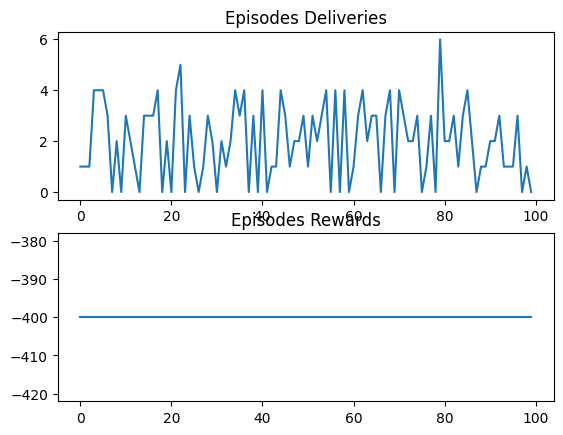

In [7]:
sgw = SquareGridWorld(grid_size=5, no_a_agents=2, no_b_agents=2)
sgw.train_multiagents(episodes=100,
                      max_steps = 100,
                      learning_rate=0.8,
                      exploration_proba=1,
                      exploration_decay=0.997,
                      min_exploration_proba=0.1,
                      update_frequency=100,
                      replay_buffer_size = 1000,
                      batch_size = 200)

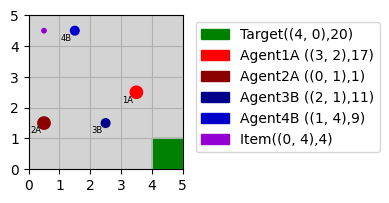

IndexError: ignored

In [16]:
sgw.evaluate( max_steps=80)